In [1]:
get_bbg_live = True

In [2]:
import pandas as pd
import random
from pydataquery import DataQuery
from matplotlib.colors import LinearSegmentedColormap
from xbbg import blp
import numpy as np
import pytz
import time
from datetime import datetime, timedelta
import statsmodels.api as sm
from ipywidgets import interact, Dropdown, HBox, VBox, Button, Output, Text, widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import re
import scipy.stats as stats
from adjustText import adjust_text
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sympy as sp
import itertools
import warnings
import openpyxl
import subprocess
import time
import pyautogui
import pygetwindow as gw
import pyodbc
import ast
warnings.filterwarnings("ignore")

In [3]:
dff = pd.read_parquet("Markit CDS.parquet")
df1 = dff[dff["close_date"]==dff["close_date"].iloc[-1]].copy()
df2 = df1[(df1["ccy"]=="USD") & (df1["docclause"]=="XR14") ].copy() #& (df1["tier"]=="SNRFOR")
len(set(df2["red"]))

233

In [4]:
df1 = dff[(dff["ccy"]=="USD") & (dff["docclause"]=="XR14") & (dff["tenor"]=="5y")].\
    drop(["docclause","ccy","tenor"],axis=1).copy()
df1["close_date"] = pd.to_datetime(df1["close_date"])
df1 = df1[(df1["close_date"]>pd.to_datetime("2018-1-1")) & ((df1["tier"]=="SNRFOR") | (df1["tier"]=="SUBLT2"))].\
    reset_index(drop=True).copy()

In [5]:
dq = pd.read_excel("Test.xlsx", sheet_name="Sheet2")
df = dq[["CDS RED Cde","Was Priv?","Rl Prim RO ISIN","Bond to Equity Ticker"]].copy()
df = df[df["Was Priv?"]=="N"].drop("Was Priv?",axis=1).copy()
df.columns = ["red","ISIN","Eqty"]

In [6]:
cds = pd.merge(left=df1,right=df, how="inner", on="red")

In [7]:
e2 = cds.copy()
e2["ID"] = e2["Eqty"] + "_" + e2["tier"]
e2 = e2.drop(["ticker","tier","Eqty"],axis=1).copy()
e2 = pd.pivot_table(columns = "ID", index = "close_date", values="spread",data=e2)


In [8]:
bbg_eqty_tickers = [item+" Equity" for item in set(cds["Eqty"])]

if get_bbg_live:
    bbg_eqty_df = blp.bdh(tickers=bbg_eqty_tickers,flds="PX_LAST", start_date='2018-1-1')
    bbg_eqty_df.columns = [item[0].replace(" Equity","") for item in bbg_eqty_df.columns]
    bbg_eqty_df.to_parquet("BBG Eqty Data.parquet")

bbg_eqty_df = pd.read_parquet("BBG Eqty Data.parquet").dropna(how="all")
avail_tickers = list(bbg_eqty_df.columns)

cds = cds[cds["Eqty"].isin(avail_tickers)].reset_index(drop=True).copy()


In [9]:
cd = cds.copy()
cd["Eqty_tier"] = cd["Eqty"] + "_" + cd["tier"]
cd = cd.drop(["tier","Eqty","ticker"],axis=1)
sprd = pd.pivot_table(columns="Eqty_tier",index="close_date",values="spread",data=cd)
sprd.columns.name = None
sprd.index.name = None
sprd = sprd[sorted(sprd.columns)]


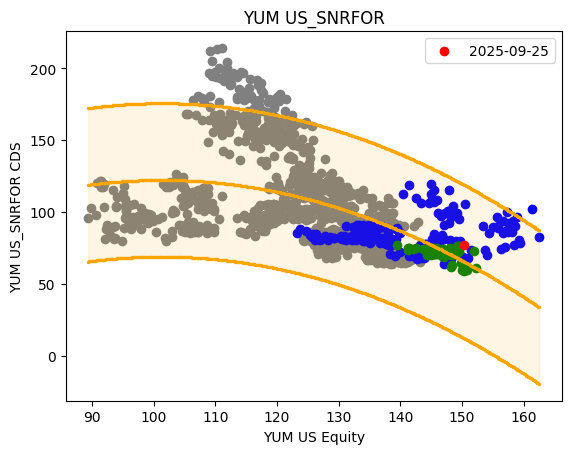

In [10]:
for col in sprd.columns:
    try:
        temp = pd.concat([sprd[col], bbg_eqty_df[col.split("_")[0]]],axis=1).dropna()
        y_col = temp.columns[0]
        x_col = temp.columns[1]
        
        
        plt.scatter(temp[x_col].iloc[:-252], temp[y_col].iloc[:-252], color="gray")
        plt.scatter(temp[x_col].iloc[-252:-63], temp[y_col].iloc[-252:-63], color="blue")
        plt.scatter(temp[x_col].iloc[-63:-1], temp[y_col].iloc[-63:-1], color="green")
        plt.scatter(temp[x_col].iloc[-1:], temp[y_col].iloc[-1:], color="red",\
                       label=f"{str(temp.index[-1])}")
    
        x_scatter = pd.to_numeric(temp[x_col], errors='coerce')
        y_scatter = pd.to_numeric(temp[y_col], errors='coerce')
        valid_mask = (~x_scatter.isna()) & (~y_scatter.isna())
        x_scatter = x_scatter[valid_mask]
        y_scatter = y_scatter[valid_mask]
        coeffs = np.polyfit(x_scatter, y_scatter, 2)
        polynomial = np.poly1d(coeffs)
        x_poly=np.linspace(min(x_scatter),max(x_scatter),500)
        y_poly=polynomial(x_poly)
        y_pred = polynomial(x_scatter)
        r2=r2_score(y_scatter,y_pred)
        equation_text = f"y = {coeffs[0]:.4f}*x² + {coeffs[1]:.4f}*x + {coeffs[2]:.4f}"
        residuals = y_scatter-y_pred
        res_sum = np.sum(residuals**2)
        dof = len(x_scatter)-len(coeffs)
        res_var = res_sum / dof
        se = np.sqrt(res_var)
        conf_upper = y_poly + 2 * se
        conf_lower = y_poly - 2 * se
        
        plt.scatter(x_poly, y_poly,color="orange",s=2)
        plt.scatter(x_poly, conf_upper,color="orange",s=2)
        plt.scatter(x_poly, conf_lower,color="orange",s=2)
        plt.fill_between(x_poly, conf_lower, conf_upper, color="orange", alpha=0.1)
        
        plt.ylabel(f"{y_col} CDS")
        plt.xlabel(f"{x_col} Equity")
        plt.title(f"{col}")
        plt.legend()
        # plt.savefig(f"CDS vs Eqty Plots/{col}.png")
        plt.show()
        # break
        clear_output(wait=True)
    except:
        continue

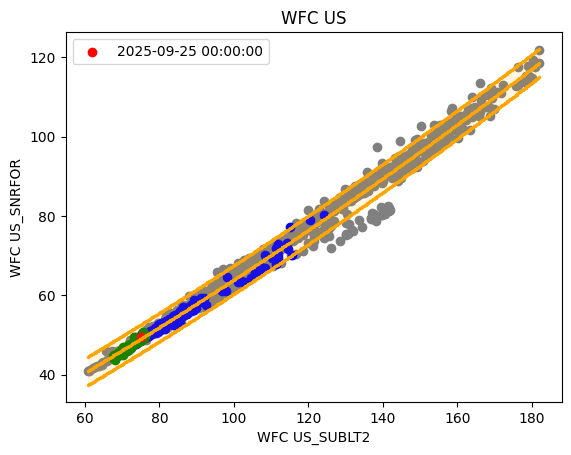

In [11]:
e = list(sorted(set([col.split("_")[0] for col in sprd.columns])))

for col in e:
    if f"{col}_SNRFOR" in sprd.columns and f"{col}_SUBLT2" in sprd.columns:
        temp = pd.concat([sprd[f"{col}_SNRFOR"], sprd[f"{col}_SUBLT2"]],axis=1).dropna()
        y_col = temp.columns[0]
        x_col = temp.columns[1]

        plt.scatter(temp[x_col].iloc[:-252], temp[y_col].iloc[:-252], color="gray")
        plt.scatter(temp[x_col].iloc[-252:-63], temp[y_col].iloc[-252:-63], color="blue")
        plt.scatter(temp[x_col].iloc[-63:-1], temp[y_col].iloc[-63:-1], color="green")
        plt.scatter(temp[x_col].iloc[-1:], temp[y_col].iloc[-1:], color="red",\
                       label=f"{str(temp.index[-1])}")
    
        x_scatter = pd.to_numeric(temp[x_col], errors='coerce')
        y_scatter = pd.to_numeric(temp[y_col], errors='coerce')
        valid_mask = (~x_scatter.isna()) & (~y_scatter.isna())
        x_scatter = x_scatter[valid_mask]
        y_scatter = y_scatter[valid_mask]
        coeffs = np.polyfit(x_scatter, y_scatter, 2)
        polynomial = np.poly1d(coeffs)
        x_poly=np.linspace(min(x_scatter),max(x_scatter),500)
        y_poly=polynomial(x_poly)
        y_pred = polynomial(x_scatter)
        r2=r2_score(y_scatter,y_pred)
        equation_text = f"y = {coeffs[0]:.4f}*x² + {coeffs[1]:.4f}*x + {coeffs[2]:.4f}"
        residuals = y_scatter-y_pred
        res_sum = np.sum(residuals**2)
        dof = len(x_scatter)-len(coeffs)
        res_var = res_sum / dof
        se = np.sqrt(res_var)
        conf_upper = y_poly + 2 * se
        conf_lower = y_poly - 2 * se
        
        plt.scatter(x_poly, y_poly,color="orange",s=2)
        plt.scatter(x_poly, conf_upper,color="orange",s=2)
        plt.scatter(x_poly, conf_lower,color="orange",s=2)
        plt.fill_between(x_poly, conf_lower, conf_upper, color="orange", alpha=0.1)
        
        plt.ylabel(f"{y_col}")
        plt.xlabel(f"{x_col}")
        plt.title(f"{col}")
        plt.legend()
        # plt.savefig(f"CDS vs Eqty Plots/{col}.png")
        plt.show()
        # break
        clear_output(wait=True)
        

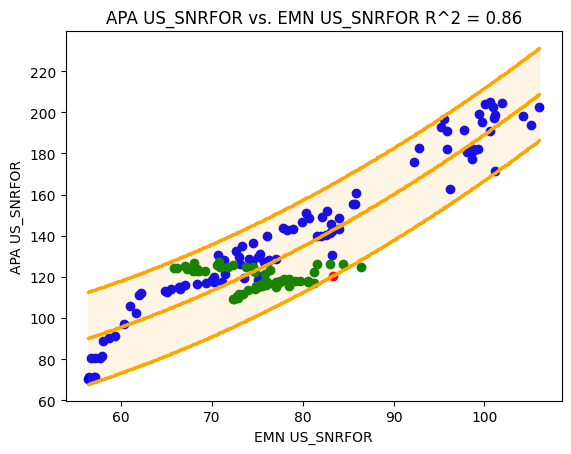

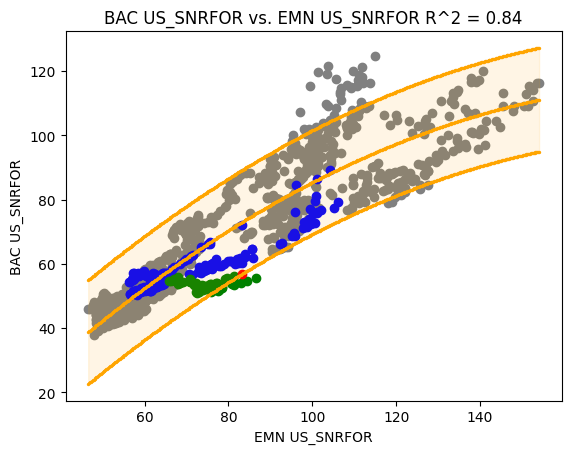

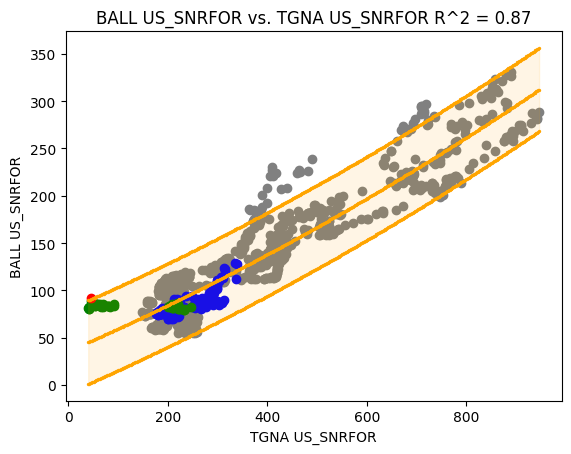

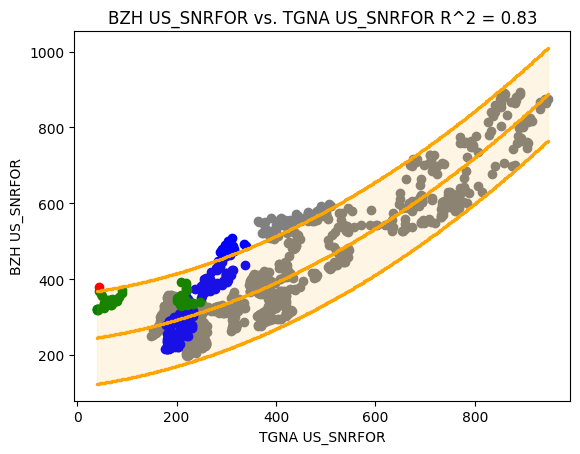

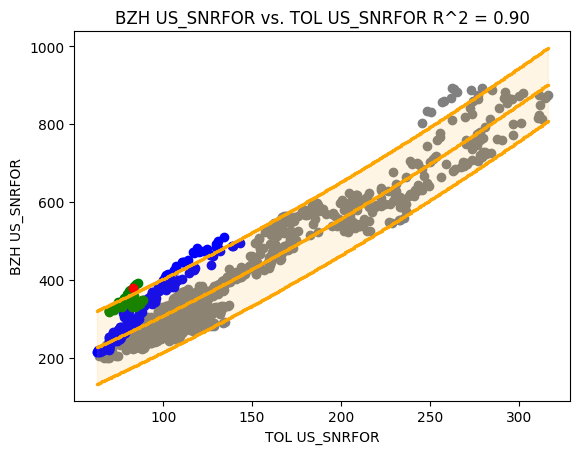

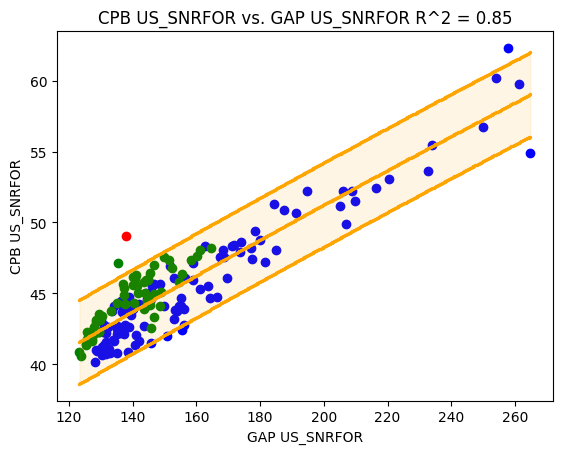

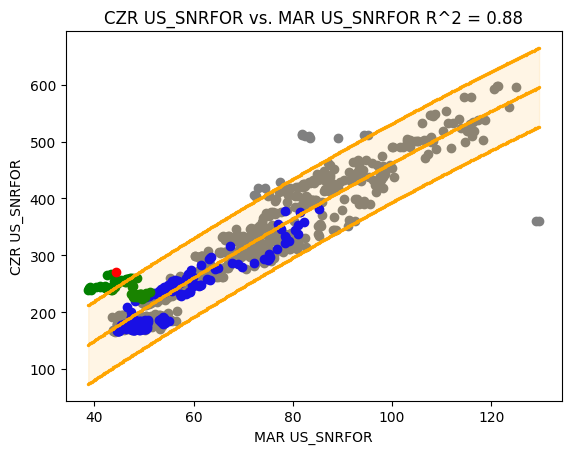

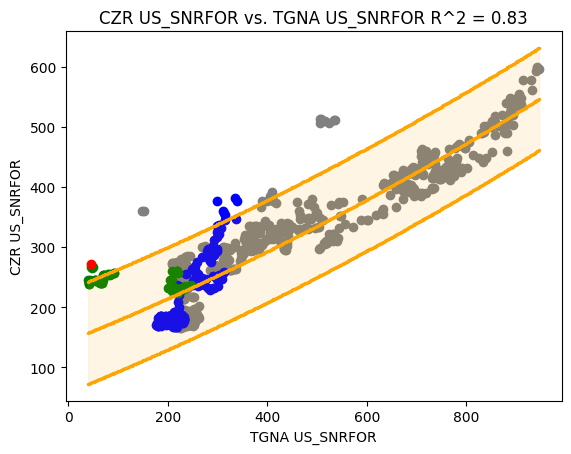

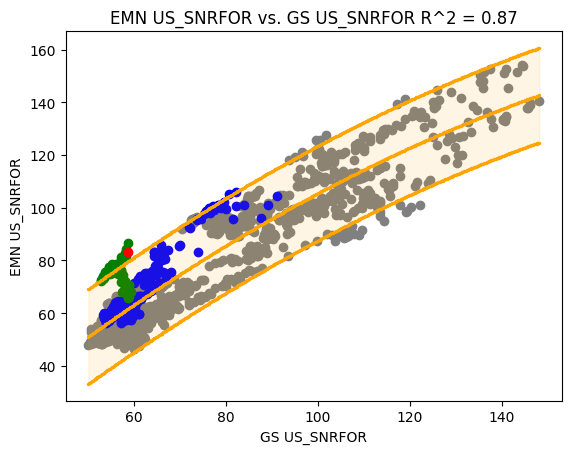

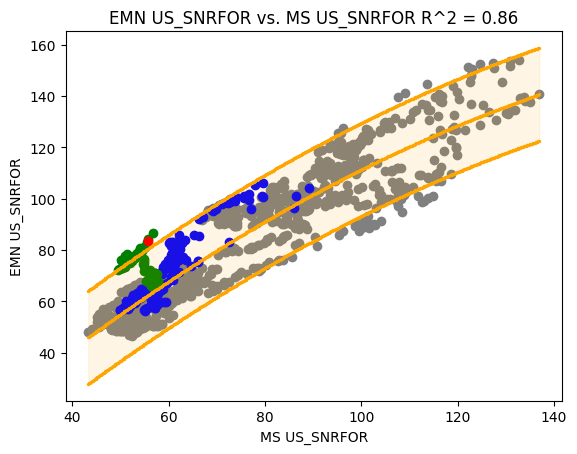

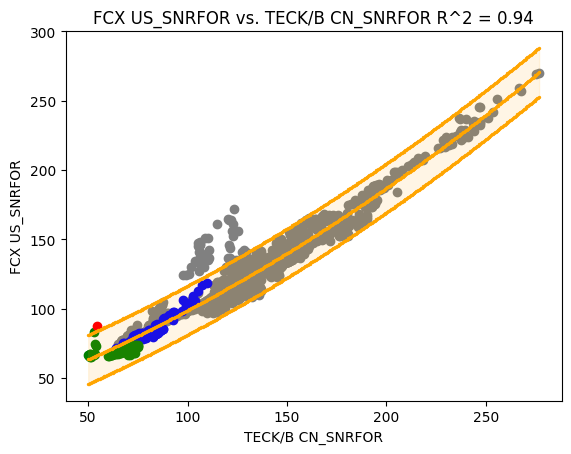

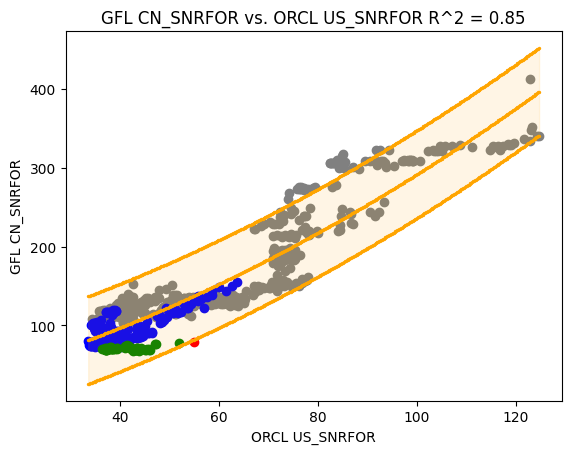

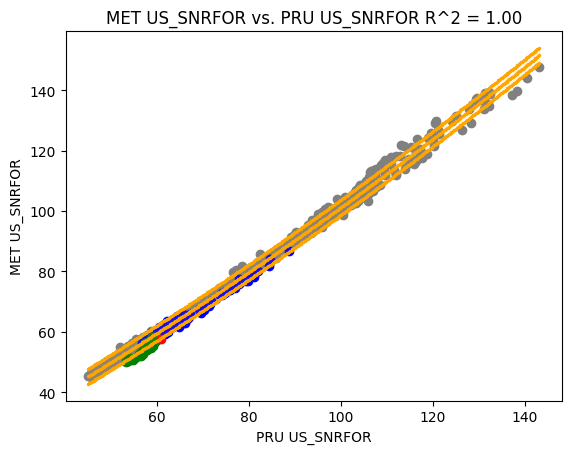

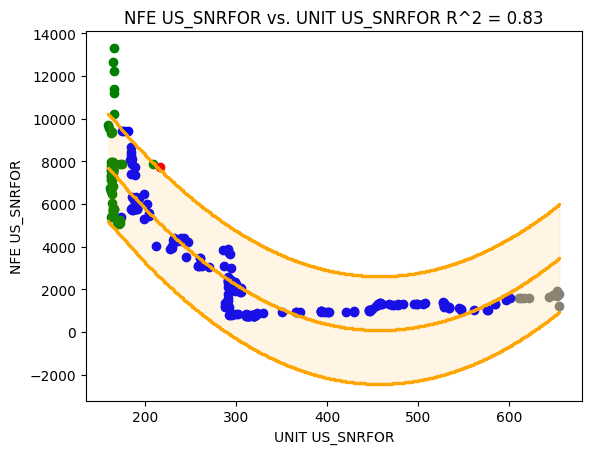

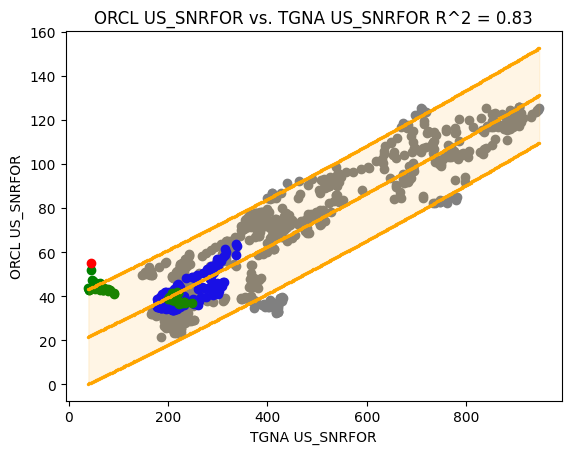

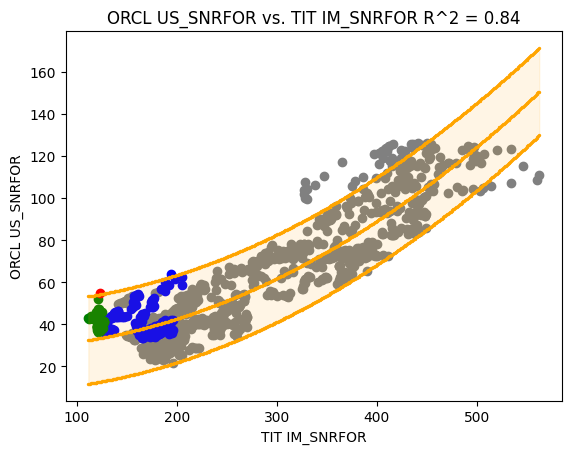

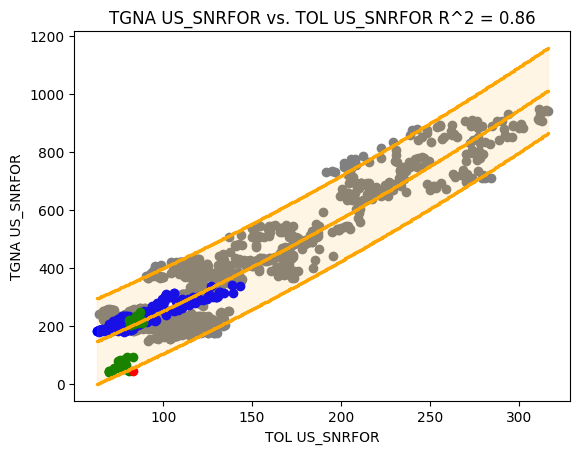

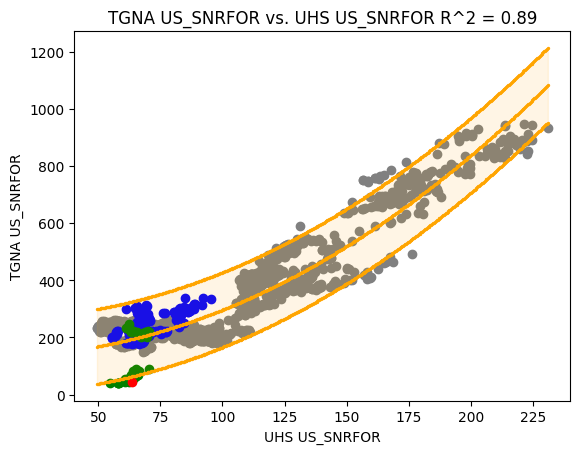

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from itertools import combinations
e = list(sorted(set([col.split("_")[0] for col in sprd.columns])))
combos = list(combinations(e, 2))

for item in combos:
# if f"{col}_SNRFOR" in sprd.columns and f"{col}_SUBLT2" in sprd.columns:
    temp = pd.concat([sprd[item[0] + "_SNRFOR"], sprd[item[1] + "_SNRFOR"]], axis=1).dropna()
    if temp.empty:
        continue

    y_col = temp.columns[0]
    x_col = temp.columns[1]

    # --- Build numeric arrays for the fit (same data you used) ---
    x_scatter = pd.to_numeric(temp[x_col], errors='coerce')
    y_scatter = pd.to_numeric(temp[y_col], errors='coerce')
    valid_mask = (~x_scatter.isna()) & (~y_scatter.isna())
    x_scatter = x_scatter[valid_mask]
    y_scatter = y_scatter[valid_mask]
    if len(x_scatter) < 3:
        continue  # need at least 3 points for quadratic

    # --- Fit quadratic and compute constant SE (your original band logic) ---
    coeffs = np.polyfit(x_scatter, y_scatter, 2)
    polynomial = np.poly1d(coeffs)
    x_poly = np.linspace(float(x_scatter.min()), float(x_scatter.max()), 500)
    y_poly = polynomial(x_poly)

    y_pred = polynomial(x_scatter)
    r2 = r2_score(y_scatter, y_pred)

    residuals = y_scatter - y_pred
    res_sum = np.sum(residuals**2)
    dof = len(x_scatter) - len(coeffs)  # n - 3
    if dof <= 0:
        continue
    res_var = res_sum / dof
    se = np.sqrt(res_var)

    conf_upper = y_poly + 2 * se
    conf_lower = y_poly - 2 * se

    # --- Gate display: check the last (red) point vs the band at its x ---
    x_last = pd.to_numeric(temp[x_col].iloc[-1], errors='coerce')
    y_last = pd.to_numeric(temp[y_col].iloc[-1], errors='coerce')
    if pd.isna(x_last) or pd.isna(y_last):
        continue

    yhat_last = polynomial(float(x_last))
    upper_last = yhat_last + 2 * se
    lower_last = yhat_last - 2 * se

    # If strictly inside band -> skip chart. On or outside -> show chart.
    if lower_last < float(y_last) < upper_last:
        continue

    if r2 >= 0.82:
        # --- PLOT (exact same layout and styles as your original) ---
        plt.scatter(temp[x_col].iloc[:-252],    temp[y_col].iloc[:-252],    color="gray")
        plt.scatter(temp[x_col].iloc[-252:-63], temp[y_col].iloc[-252:-63], color="blue")
        plt.scatter(temp[x_col].iloc[-63:-1],   temp[y_col].iloc[-63:-1],   color="green")
        plt.scatter(temp[x_col].iloc[-1:],      temp[y_col].iloc[-1:],      color="red",
                    label=f"{str(temp.index[-1])}")
    
        # Orange curve + bands (using your scatter + fill_between)
        plt.scatter(x_poly, y_poly,       color="orange", s=2)
        plt.scatter(x_poly, conf_upper,   color="orange", s=2)
        plt.scatter(x_poly, conf_lower,   color="orange", s=2)
        plt.fill_between(x_poly, conf_lower, conf_upper, color="orange", alpha=0.1)
    
        plt.ylabel(f"{y_col}")
        plt.xlabel(f"{x_col}")
        plt.title(f"{y_col} vs. {x_col} R^2 = {r2:.2f}")
        plt.show()
    # break

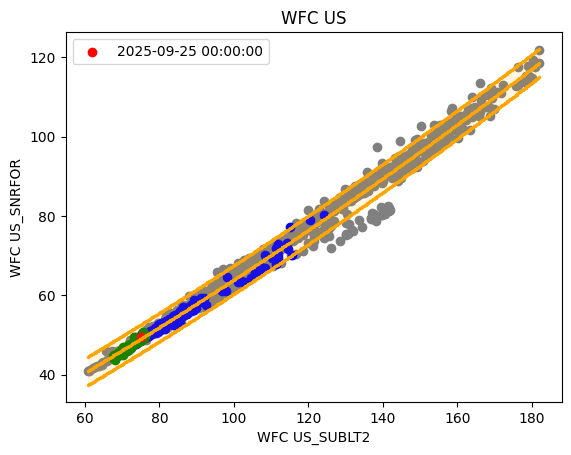

In [13]:
e2a = list(sorted(set([col.split("_")[0] for col in e2.columns])))

for col in e2a:
    if f"{col}_SNRFOR" in e2.columns and f"{col}_SUBLT2" in e2.columns:
        temp = pd.concat([e2[f"{col}_SNRFOR"], e2[f"{col}_SUBLT2"]],axis=1).dropna()
        y_col = temp.columns[0]
        x_col = temp.columns[1]

        plt.scatter(temp[x_col].iloc[:-252], temp[y_col].iloc[:-252], color="gray")
        plt.scatter(temp[x_col].iloc[-252:-63], temp[y_col].iloc[-252:-63], color="blue")
        plt.scatter(temp[x_col].iloc[-63:-1], temp[y_col].iloc[-63:-1], color="green")
        plt.scatter(temp[x_col].iloc[-1:], temp[y_col].iloc[-1:], color="red",\
                       label=f"{str(temp.index[-1])}")
    
        x_scatter = pd.to_numeric(temp[x_col], errors='coerce')
        y_scatter = pd.to_numeric(temp[y_col], errors='coerce')
        valid_mask = (~x_scatter.isna()) & (~y_scatter.isna())
        x_scatter = x_scatter[valid_mask]
        y_scatter = y_scatter[valid_mask]
        coeffs = np.polyfit(x_scatter, y_scatter, 2)
        polynomial = np.poly1d(coeffs)
        x_poly=np.linspace(min(x_scatter),max(x_scatter),500)
        y_poly=polynomial(x_poly)
        y_pred = polynomial(x_scatter)
        r2=r2_score(y_scatter,y_pred)
        equation_text = f"y = {coeffs[0]:.4f}*x² + {coeffs[1]:.4f}*x + {coeffs[2]:.4f}"
        residuals = y_scatter-y_pred
        res_sum = np.sum(residuals**2)
        dof = len(x_scatter)-len(coeffs)
        res_var = res_sum / dof
        se = np.sqrt(res_var)
        conf_upper = y_poly + 2 * se
        conf_lower = y_poly - 2 * se
        
        plt.scatter(x_poly, y_poly,color="orange",s=2)
        plt.scatter(x_poly, conf_upper,color="orange",s=2)
        plt.scatter(x_poly, conf_lower,color="orange",s=2)
        plt.fill_between(x_poly, conf_lower, conf_upper, color="orange", alpha=0.1)
        
        plt.ylabel(f"{y_col}")
        plt.xlabel(f"{x_col}")
        plt.title(f"{col}")
        plt.legend()
        # plt.savefig(f"CDS vs Eqty Plots/{col}.png")
        plt.show()
        # break
        clear_output(wait=True)
        

In [14]:
for col in bbg_eqty_df.columns:
    if col+"_SNRFOR" in sprd.columns:
        # bbg_eqty_df[col].dropna()
        # sprd[col+"_SNRFOR"].dropna()
        display(col)
        # break
    clear_output(wait=True)

'AIG US'

In [15]:
from scipy.stats import rankdata

eqty_df = bbg_eqty_df.apply(lambda x: pd.Series(rankdata(x.dropna(), method='average') / len(x.dropna()), index=x.dropna().index))#.iloc[[-1],:]
sprd_df = sprd.apply(lambda x: pd.Series(rankdata(x.dropna(), method='average') / len(x.dropna()), index=x.dropna().index))#.iloc[[-1],:]

eqty_df.index = pd.to_datetime(eqty_df.index)
sprd_df.index = pd.to_datetime(sprd_df.index)

sprd_df

,AAL US_SNRFOR,ABT US_SNRFOR,AES US_SNRFOR,AES US_SUBLT2,AIG US_SNRFOR,ALLY US_SNRFOR,ALLY US_SUBLT2,AMD US_SNRFOR,AMGN US_SNRFOR,AMKR US_SNRFOR,...,UBER US_SNRFOR,UHS US_SNRFOR,UIS US_SNRFOR,UNIT US_SNRFOR,VLO US_SNRFOR,VST US_SNRFOR,WFC US_SNRFOR,WFC US_SUBLT2,WHR US_SNRFOR,YUM US_SNRFOR
2020-08-19,0.992492,0.972932,0.370871,0.371041,0.549550,0.253754,NaN,0.120120,0.006006,0.044294,...,NaN,0.278529,0.045796,0.529279,0.302553,NaN,0.565414,0.553383,0.016517,0.666667
2020-08-20,0.993994,0.973684,0.350601,0.351433,0.544294,0.256006,NaN,0.117868,0.005255,0.079580,...,NaN,0.282282,0.044294,0.537538,0.299550,NaN,0.566917,0.557895,0.015766,0.670420
2020-08-21,1.000000,0.972180,0.348348,0.347662,0.550300,0.258258,NaN,0.118619,0.004505,0.069069,...,NaN,0.284535,0.045045,0.543544,0.307057,NaN,0.560902,0.551128,0.015015,0.677928
2020-08-24,0.999249,0.751880,0.328829,0.329563,0.524024,0.250751,NaN,0.116366,0.003754,0.073574,...,NaN,0.268769,0.042042,0.545045,0.298048,NaN,0.536090,0.541353,0.014264,0.544294
2020-08-25,0.998498,0.766165,0.329580,0.330317,0.518769,0.249249,NaN,0.113363,0.003003,0.116366,...,NaN,0.260511,0.042793,0.547297,0.282282,NaN,0.542857,0.536842,0.011261,0.525526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-19,0.141892,0.000752,0.262763,0.259427,0.033784,0.259009,0.278884,0.027778,0.083333,0.162913,...,0.000956,0.032282,0.421922,0.000751,0.041291,0.162986,0.011278,0.020301,0.963213,0.088589
2025-09-22,0.162913,0.004511,0.334835,0.337858,0.171922,0.310060,0.689243,0.147147,0.293544,0.229730,...,0.035373,0.101351,0.454955,0.045045,0.117868,0.161462,0.060150,0.042857,0.974474,0.171171
2025-09-23,0.178679,0.002256,0.346847,0.346908,0.156156,0.322072,0.553785,0.121622,0.274024,0.239489,...,0.036329,0.090090,0.449700,0.047297,0.114865,0.169078,0.078195,0.064662,0.982733,0.176426
2025-09-24,0.186937,0.003008,0.355105,0.356712,0.182432,0.346847,0.601594,0.157658,0.329580,0.237237,...,0.034417,0.108859,0.453453,0.072072,0.124625,0.170602,0.111278,0.093233,0.983483,0.178679


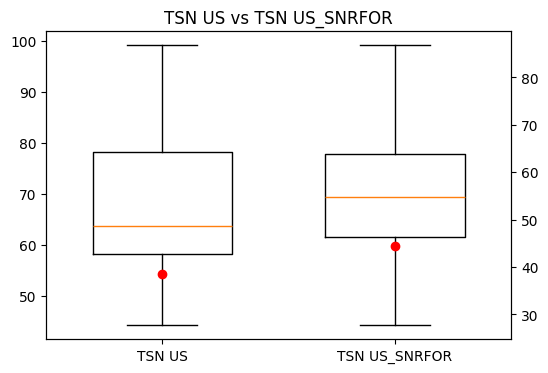

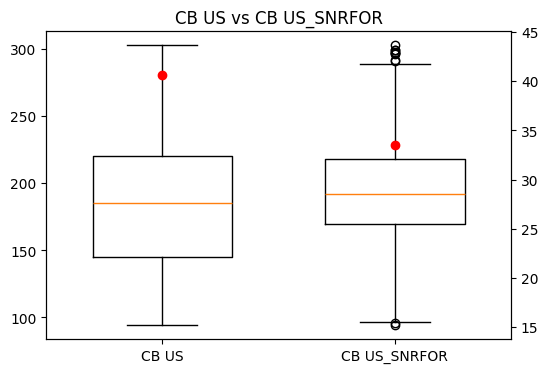

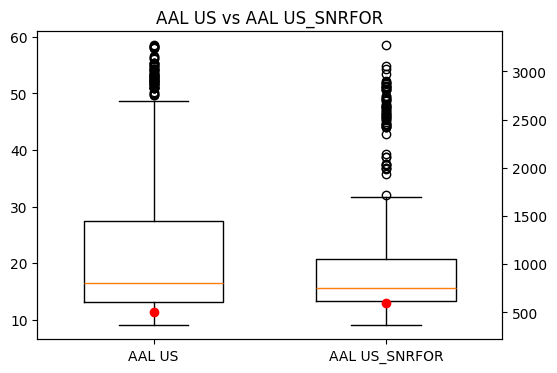

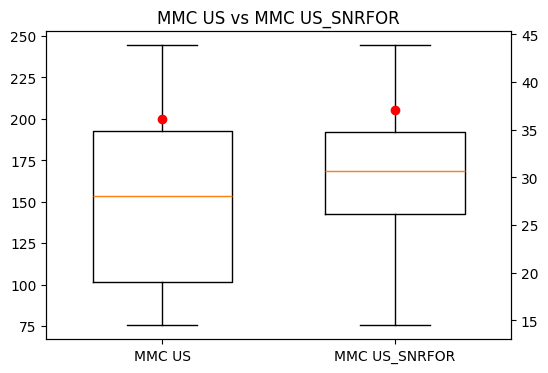

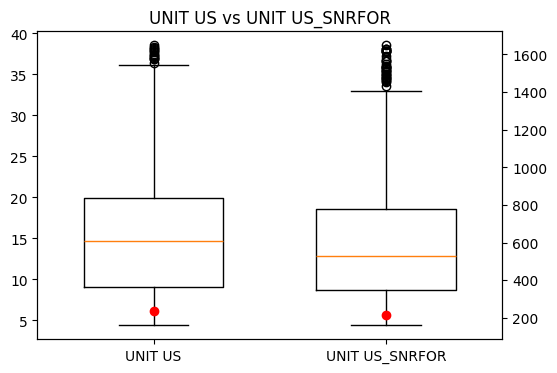

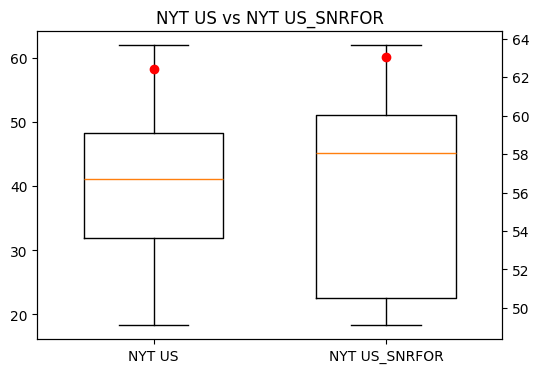

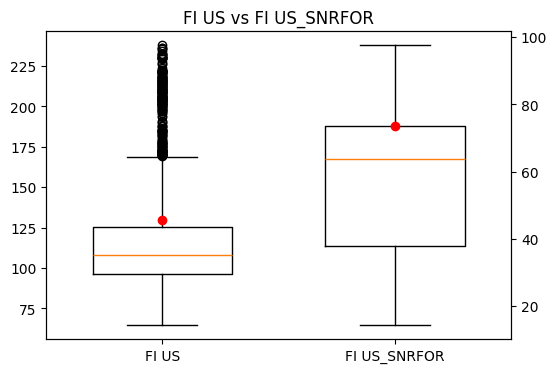

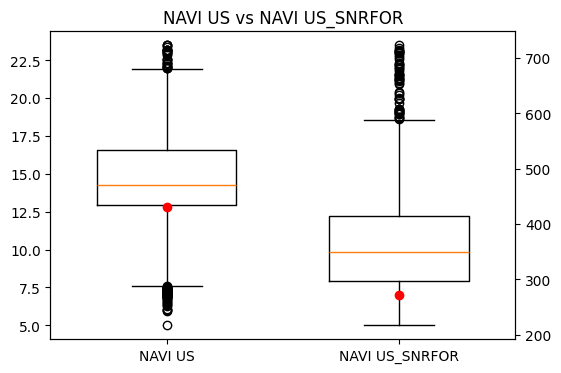

In [16]:
import matplotlib.pyplot as plt

bg = bbg_eqty_df.copy()
bg.index = pd.to_datetime(bg.index)
sp = sprd.copy()
sp.index = pd.to_datetime(sp.index)

for col in eqty_df.columns:
    sprd_col = col + '_SNRFOR'
    
    if sprd_col in sprd_df.columns:
        last_eqty_val = eqty_df[col].iloc[-1]
        last_sprd_val = sprd_df[sprd_col].iloc[-1]
        
        if ((last_eqty_val <= 0.25 and last_sprd_val <= 0.25) or
            (last_eqty_val >= 0.75 and last_sprd_val >= 0.75)):
            
            last_eqty_val = bg[col].iloc[-1]
            last_sprd_val = sp[sprd_col].iloc[-1]
            
            fig, ax1 = plt.subplots(figsize=(6, 4))
            ax2 = ax1.twinx()

            # Boxplot for the first dataset on primary y-axis
            bp1 = ax1.boxplot(bg[col].dropna(), positions=[1], widths=0.6)
            ax1.plot(1, last_eqty_val, 'ro')  # Red dot for eqty_df

            # Boxplot for the second dataset on secondary y-axis
            bp2 = ax2.boxplot(sp[sprd_col].dropna(), positions=[2], widths=0.6)
            ax2.plot(2, last_sprd_val, 'ro')  # Red dot for sprd_df

            ax1.set_xticks([1, 2])
            ax1.set_xticklabels([col, sprd_col])
            plt.title(f'{col} vs {sprd_col}')
            
            plt.show()



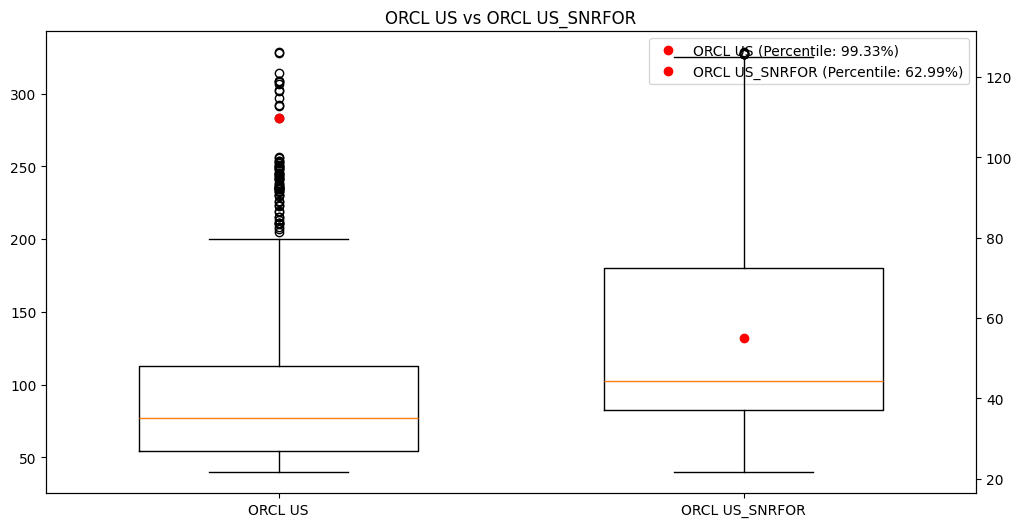

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

bg = bbg_eqty_df.copy()
bg.index = pd.to_datetime(bg.index)
sp = sprd.copy()
sp.index = pd.to_datetime(sp.index)

for col in ["ORCL US"]:#sorted(eqty_df.columns):
    
    sprd_col = col + '_SNRFOR'
    
    if sprd_col in sprd_df.columns:
        last_eqty_val = eqty_df[col].iloc[-1]
        last_sprd_val = sprd_df[sprd_col].iloc[-1]
        
        # if ((last_eqty_val <= 0.25 and last_sprd_val <= 0.25) or
        #     (last_eqty_val >= 0.75 and last_sprd_val >= 0.75)):
            
        last_eqty_val = bg[col].iloc[-1]
        last_sprd_val = sp[sprd_col].iloc[-1]
        
        # Calculate percentiles
        eqty_percentile = np.round((bg[col].dropna() < last_eqty_val).mean() * 100, 2)
        sprd_percentile = np.round((sp[sprd_col].dropna() < last_sprd_val).mean() * 100, 2)
        
        fig, ax1 = plt.subplots(figsize=(12, 6))
        ax2 = ax1.twinx()

        # Boxplot for the first dataset on primary y-axis
        bp1 = ax1.boxplot(bg[col].dropna(), positions=[1], widths=0.6)
        ax1.plot(1, last_eqty_val, 'ro', label=f'{col} (Percentile: {eqty_percentile}%)')

        # Boxplot for the second dataset on secondary y-axis
        bp2 = ax2.boxplot(sp[sprd_col].dropna(), positions=[2], widths=0.6)
        ax2.plot(2, last_sprd_val, 'ro', label=f'{sprd_col} (Percentile: {sprd_percentile}%)')

        ax1.set_xticks([1, 2])
        ax1.set_xticklabels([col, sprd_col])
        plt.title(f'{col} vs {sprd_col}')
        
        # Combine legends from both axes
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper right')
        
        plt.show()
        if col=="ORCL US":
            break


                            OLS Regression Results                            
Dep. Variable:         ORCL US_SNRFOR   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     79.30
Date:                Fri, 26 Sep 2025   Prob (F-statistic):           1.79e-18
Time:                        18:47:55   Log-Likelihood:                -670.14
No. Observations:                1282   AIC:                             1344.
Df Residuals:                    1280   BIC:                             1355.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1780      0.140     37.084      0.0

0.5011177242719804

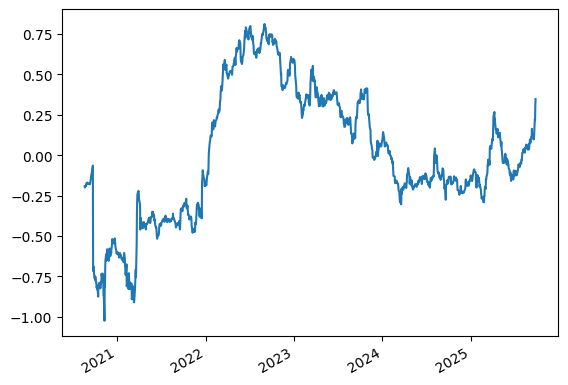

In [20]:
from statsmodels.tsa.stattools import adfuller
o = pd.concat([sp[sprd_col], bg[col]],axis=1).dropna()
o = o.resample("M").last()
o = np.log(o)
X = o[["ORCL US"]]
Y = o[["ORCL US_SNRFOR"]]
model = sm.OLS(Y, sm.add_constant(X)).fit()
print(model.summary())
model.resid.plot()
adfuller(model.resid)[1]

<Axes: >

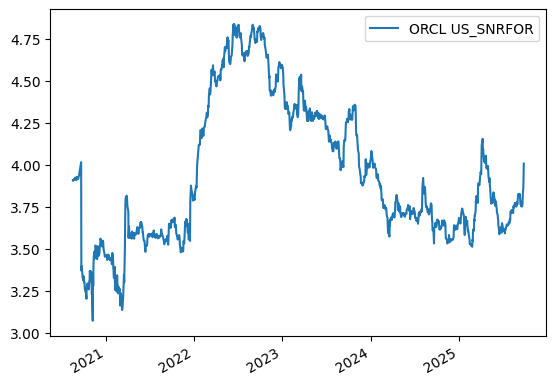

In [22]:
Y.plot()

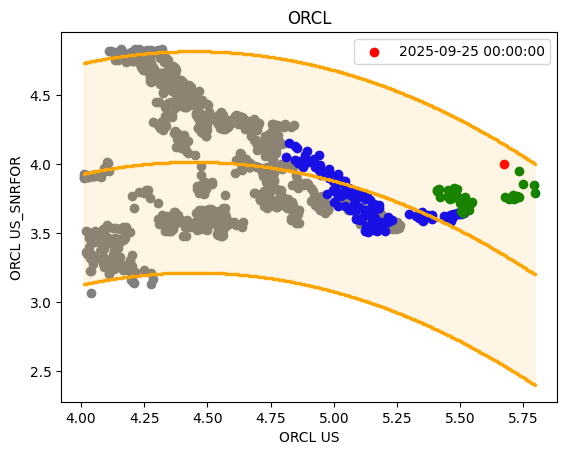

In [26]:
orcl = pd.read_excel("Test.xlsx",index_col=0,parse_dates=True,sheet_name="Sheet3").dropna()
# orcl = np.log(orcl)
# orcl = orcl.diff().dropna()
temp = orcl[["ORCL CDS","ORCL Eq"]]
# plt.scatter(orcl["ORCL Eq"],orcl["ORCL CDS"])

o = pd.concat([sp[sprd_col], bg[col]],axis=1).dropna()
o = o.resample("D").last()
temp = np.log(o.copy())

y_col = temp.columns[0]
x_col = temp.columns[1]

plt.scatter(temp[x_col].iloc[:-252], temp[y_col].iloc[:-252], color="gray")
plt.scatter(temp[x_col].iloc[-252:-63], temp[y_col].iloc[-252:-63], color="blue")
plt.scatter(temp[x_col].iloc[-63:-1], temp[y_col].iloc[-63:-1], color="green")
plt.scatter(temp[x_col].iloc[-1:], temp[y_col].iloc[-1:], color="red",\
               label=f"{str(temp.index[-1])}")

x_scatter = pd.to_numeric(temp[x_col], errors='coerce')
y_scatter = pd.to_numeric(temp[y_col], errors='coerce')
valid_mask = (~x_scatter.isna()) & (~y_scatter.isna())
x_scatter = x_scatter[valid_mask]
y_scatter = y_scatter[valid_mask]
coeffs = np.polyfit(x_scatter, y_scatter, 2)
polynomial = np.poly1d(coeffs)
x_poly=np.linspace(min(x_scatter),max(x_scatter),500)
y_poly=polynomial(x_poly)
y_pred = polynomial(x_scatter)
r2=r2_score(y_scatter,y_pred)
equation_text = f"y = {coeffs[0]:.4f}*x² + {coeffs[1]:.4f}*x + {coeffs[2]:.4f}"
residuals = y_scatter-y_pred
res_sum = np.sum(residuals**2)
dof = len(x_scatter)-len(coeffs)
res_var = res_sum / dof
se = np.sqrt(res_var)
conf_upper = y_poly + 2 * se
conf_lower = y_poly - 2 * se

plt.scatter(x_poly, y_poly,color="orange",s=2)
plt.scatter(x_poly, conf_upper,color="orange",s=2)
plt.scatter(x_poly, conf_lower,color="orange",s=2)
plt.fill_between(x_poly, conf_lower, conf_upper, color="orange", alpha=0.1)

plt.ylabel(f"{y_col}")
plt.xlabel(f"{x_col}")
plt.title(f"ORCL")
plt.legend()
# plt.savefig(f"CDS vs Eqty Plots/{col}.png")
plt.show()
# break

<Axes: xlabel='Date'>

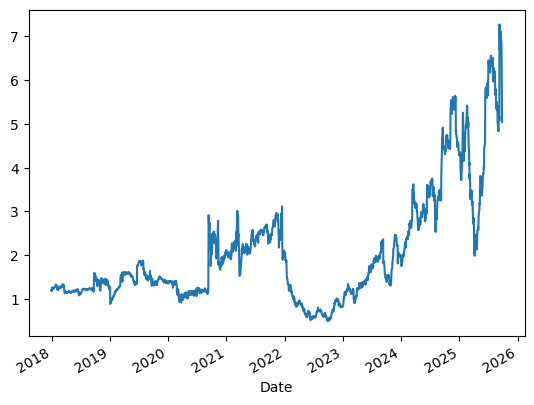

In [85]:
(orcl["ORCL Eq"]/orcl["ORCL CDS"]).plot()